<a href="https://colab.research.google.com/github/daniui/computational-intelligence-task/blob/main/Project_UAS_Individu_KI_Pak_Risman_Hilmy_Rahmadani_2206810490_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Translation

##Import

In [1]:
from google import colab
colab.drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch-summary

In [3]:
import torch.nn.functional as F
from torch.nn import Module
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import re
import tensorflow as tf

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

##Data Preprocessing

In [5]:
import pandas as pd
df_translation = pd.read_csv("/content/drive/MyDrive/tugas project kuliah/Komputasi Intelegensia/Sentence pairs in English-Indonesian - 2024-12-17.tsv", sep='\t')
df_translation

,1277,I have to go to sleep.,1063736,Aku harus pergi tidur.
0,1277,I have to go to sleep.,2167926,Saya harus tidur.
1,1282,Muiriel is 20 now.,2167927,Muiriel berumur 20 sekarang.
2,1287,This is never going to end.,3389252,Hal ini tidak akan pernah berakhir.
3,1295,You're in better shape than I am.,3389296,Anda berada dalam kondisi yang lebih baik dari...
4,1296,You are in my way.,1061743,Kau berada di jalanku.
...,...,...,...,...
22832,12913865,Icelanders learn Danish and English at school.,12915416,Anak-anak Islandia belajar bahasa Denmark dan ...
22833,12099123,Agnosia is a neurological disorder characteriz...,12915627,Agnosia adalah gangguan neurologis yang ditand...
22834,637805,"Botulism, brucellosis, Lyme-disease and tetanu...",12915647,"Botulisme, bruselosis, penyakit Lyme, dan teta..."
22835,6013072,Multilingualism may prevent dementia.,12915648,Multilingualisme dapat mencegah demensia.


In [6]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

df_translation = df_translation.rename(columns={
    '1277': 'a',
    'I have to go to sleep.': 'eng',
    '1063736': 'c',
    'Aku harus pergi tidur.': 'id'
})
english_sentences = df_translation['eng']
indonesian_sentences = df_translation['id']
english_sentences


,eng
0,I have to go to sleep.
1,Muiriel is 20 now.
2,This is never going to end.
3,You're in better shape than I am.
4,You are in my way.
...,...
22832,Icelanders learn Danish and English at school.
22833,Agnosia is a neurological disorder characteriz...
22834,"Botulism, brucellosis, Lyme-disease and tetanu..."
22835,Multilingualism may prevent dementia.


In [7]:
# Tokenization
english_sentences = english_sentences.apply(word_tokenize)
indonesian_sentences = indonesian_sentences.apply(word_tokenize)
english_sentences

,eng
0,"[I, have, to, go, to, sleep, .]"
1,"[Muiriel, is, 20, now, .]"
2,"[This, is, never, going, to, end, .]"
3,"[You, 're, in, better, shape, than, I, am, .]"
4,"[You, are, in, my, way, .]"
...,...
22832,"[Icelanders, learn, Danish, and, English, at, ..."
22833,"[Agnosia, is, a, neurological, disorder, chara..."
22834,"[Botulism, ,, brucellosis, ,, Lyme-disease, an..."
22835,"[Multilingualism, may, prevent, dementia, .]"


In [8]:
# Vocabulary creation
def build_vocab(sentences):
    vocab = set(word for sentence in sentences for word in sentence)
    word2idx = {word: idx+2 for idx, word in enumerate(vocab)}
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

english_vocab, idx2word_en = build_vocab(english_sentences)
indonesian_vocab, idx2word_id = build_vocab(indonesian_sentences)
print(english_vocab)
print(idx2word_en)

{'temples': 2, 'vegetarian': 3, 'tile': 4, 'Tobias': 5, 'changes': 6, 'tool': 7, 'bookkeeper': 8, 'matches': 9, 'bloom': 10, 'servitude': 11, 'east': 12, 'lawn': 13, 'make': 14, 'argue': 15, 'err': 16, 'effects': 17, 'if': 18, 'Kate': 19, 'accompanied': 20, 'sausage': 21, 'ensure': 22, 'coat': 23, 'craft': 24, 'recorded': 25, 'Ferguson': 26, 'Yahoo': 27, 'smiling': 28, 'Charlotte': 29, 'Tom': 30, 'Hogwarts': 31, 'Hokkaido': 32, 'dropping': 33, 'Jersey': 34, 'Knitting': 35, 'immune': 36, 'geography': 37, 'kiss': 38, 'Hausa': 39, 'written': 40, 'contagious': 41, 'butter': 42, 'euros': 43, 'Floyd': 44, 'distance': 45, 'Why': 46, 'reconsider': 47, 'USSR': 48, 'puppy': 49, 'anxious': 50, 'Italy': 51, 'expecting': 52, 'Virginia': 53, 'rugby': 54, 'teachable': 55, 'helped': 56, 'court': 57, 'expensive': 58, 'Their': 59, 'Faster': 60, 'sky': 61, 'spending': 62, 'Put': 63, 'cooker': 64, '8': 65, 'pool': 66, 'Saturday': 67, 'Beetles': 68, 'copyright': 69, 'pollution': 70, 'Relax': 71, 'discoveri

In [9]:
# Encode sentences
def encode_sentence(sentence, word2idx, max_len):
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence[:max_len]] + [word2idx['<pad>']] * (max_len - len(sentence))

max_len_en = len(idx2word_en)
max_len_id = len(idx2word_id)

english_sentences2 = english_sentences.copy()
indonesian_sentences2 = indonesian_sentences.copy()
english_sentences2 = english_sentences2.apply(lambda x: encode_sentence(x, english_vocab, max_len_en))
indonesian_sentences2 = indonesian_sentences2.apply(lambda x: encode_sentence(x, indonesian_vocab, max_len_id))
indonesian_sentences2

,id
0,"[8936, 932, 4162, 5308, 0, 0, 0, 0, 0, 0, 0, 0..."
1,"[550, 2861, 4990, 4967, 5308, 0, 0, 0, 0, 0, 0..."
2,"[4090, 9617, 5371, 7704, 10376, 8219, 5308, 0,..."
3,"[7577, 4628, 10198, 8431, 6273, 462, 7249, 662..."
4,"[8727, 4628, 4515, 8330, 5308, 0, 0, 0, 0, 0, ..."
...,...
22832,"[9608, 8851, 4645, 2614, 410, 5231, 1122, 4515..."
22833,"[880, 3695, 6532, 1128, 6273, 5737, 1882, 7510..."
22834,"[4634, 3145, 9274, 3145, 6549, 7810, 3145, 523..."
22835,"[8767, 5639, 9102, 1769, 5308, 0, 0, 0, 0, 0, ..."


In [10]:
english_sentences2

,eng
0,"[2196, 4644, 7139, 4079, 7139, 5107, 4360, 0, ..."
1,"[492, 3904, 4071, 3027, 4360, 0, 0, 0, 0, 0, 0..."
2,"[859, 3904, 3837, 8640, 7139, 1453, 4360, 0, 0..."
3,"[4241, 6535, 7382, 2981, 3048, 1487, 2196, 588..."
4,"[4241, 7990, 7382, 3290, 6926, 4360, 0, 0, 0, ..."
...,...
22832,"[753, 6817, 8641, 3223, 2915, 1579, 6602, 4360..."
22833,"[785, 3904, 4056, 411, 1403, 7347, 4921, 8775,..."
22834,"[2072, 2579, 4461, 2579, 3504, 3223, 565, 7990..."
22835,"[4387, 1950, 6143, 4453, 4360, 0, 0, 0, 0, 0, ..."


In [11]:
# Encode sentences
def encode_sentence(sentence, word2idx, max_len):
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence[:max_len]] + [word2idx['<pad>']] * (max_len - len(sentence))

max_len_en = 50
max_len_id = 50

english_sentences3 = english_sentences.copy()
indonesian_sentences3 = indonesian_sentences.copy()
english_sentences3 = english_sentences.apply(lambda x: encode_sentence(x, english_vocab, max_len_en))
indonesian_sentences3 = indonesian_sentences.apply(lambda x: encode_sentence(x, indonesian_vocab, max_len_id))
indonesian_sentences3

,id
0,"[8936, 932, 4162, 5308, 0, 0, 0, 0, 0, 0, 0, 0..."
1,"[550, 2861, 4990, 4967, 5308, 0, 0, 0, 0, 0, 0..."
2,"[4090, 9617, 5371, 7704, 10376, 8219, 5308, 0,..."
3,"[7577, 4628, 10198, 8431, 6273, 462, 7249, 662..."
4,"[8727, 4628, 4515, 8330, 5308, 0, 0, 0, 0, 0, ..."
...,...
22832,"[9608, 8851, 4645, 2614, 410, 5231, 1122, 4515..."
22833,"[880, 3695, 6532, 1128, 6273, 5737, 1882, 7510..."
22834,"[4634, 3145, 9274, 3145, 6549, 7810, 3145, 523..."
22835,"[8767, 5639, 9102, 1769, 5308, 0, 0, 0, 0, 0, ..."


In [12]:
english_sentences3

,eng
0,"[2196, 4644, 7139, 4079, 7139, 5107, 4360, 0, ..."
1,"[492, 3904, 4071, 3027, 4360, 0, 0, 0, 0, 0, 0..."
2,"[859, 3904, 3837, 8640, 7139, 1453, 4360, 0, 0..."
3,"[4241, 6535, 7382, 2981, 3048, 1487, 2196, 588..."
4,"[4241, 7990, 7382, 3290, 6926, 4360, 0, 0, 0, ..."
...,...
22832,"[753, 6817, 8641, 3223, 2915, 1579, 6602, 4360..."
22833,"[785, 3904, 4056, 411, 1403, 7347, 4921, 8775,..."
22834,"[2072, 2579, 4461, 2579, 3504, 3223, 565, 7990..."
22835,"[4387, 1950, 6143, 4453, 4360, 0, 0, 0, 0, 0, ..."


##Model Building

In [13]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, output_dim, emb_dim, hidden_dim, num_layers, dropout=0.2):
        super().__init__()
        self.encoder_emb = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.decoder_emb = nn.Embedding(output_dim, emb_dim, padding_idx=0)

        self.encoder_lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, dropout=dropout)
        self.decoder_lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, dropout=dropout)

        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, trg):
        # Encoder
        _, (hidden, cell) = self.encoder_lstm(self.encoder_emb(src))

        # Decoder
        outputs, _ = self.decoder_lstm(self.decoder_emb(trg), (hidden, cell))
        predictions = self.fc_out(outputs)
        return predictions

In [14]:
class Seq2SeqRNN(Module):
    def __init__(self, input_dim, output_dim, emb_dim, hidden_dim, num_layers):
        super().__init__()
        self.encoder_emb = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.decoder_emb = nn.Embedding(output_dim, emb_dim, padding_idx=0)
        self.encoder_rnn = nn.RNN(emb_dim, hidden_dim, num_layers)
        self.decoder_rnn = nn.RNN(emb_dim, hidden_dim, num_layers)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, src, trg):
        _, hidden = self.encoder_rnn(self.encoder_emb(src))
        outputs, _ = self.decoder_rnn(self.decoder_emb(trg), hidden)
        predictions = self.fc_out(outputs)
        return predictions

##Training

In [15]:
# Split into train, test, validation
X_train, X_val, y_train, y_val = train_test_split(english_sentences3, indonesian_sentences3, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 20% of 80%
X_train

,eng
18502,"[2196, 4644, 6653, 5897, 2198, 1615, 4360, 0, ..."
19647,"[2196, 4899, 4041, 5805, 4360, 0, 0, 0, 0, 0, ..."
4569,"[859, 274, 3904, 3692, 4360, 0, 0, 0, 0, 0, 0,..."
15019,"[6514, 5608, 6535, 4779, 4360, 0, 0, 0, 0, 0, ..."
140,"[6064, 5255, 5107, 1579, 8613, 3934, 3883, 405..."
...,...
3799,"[7040, 5871, 5608, 1120, 4056, 4843, 8790, 708..."
3555,"[30, 3390, 6116, 2480, 1792, 3584, 1965, 7261,..."
1451,"[481, 7475, 3904, 6207, 5894, 1579, 7087, 4360..."
16851,"[30, 3390, 6116, 8416, 7490, 4360, 0, 0, 0, 0,..."


In [19]:
X_val

,eng
11883,"[298, 3686, 288, 30, 2893, 2168, 1543, 3190, 7..."
10138,"[259, 4146, 4360, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
20549,"[8822, 5608, 7212, 4346, 2389, 4360, 0, 0, 0, ..."
12573,"[8159, 6653, 4306, 4346, 4829, 4360, 0, 0, 0, ..."
2533,"[1398, 2196, 425, 4346, 1347, 7084, 0, 0, 0, 0..."
...,...
9566,"[2693, 8735, 2216, 4360, 0, 0, 0, 0, 0, 0, 0, ..."
17181,"[30, 7531, 6653, 2076, 1313, 149, 4360, 0, 0, ..."
8518,"[2196, 7438, 2196, 816, 2389, 30, 8315, 7261, ..."
3481,"[4802, 2902, 4406, 555, 7084, 0, 0, 0, 0, 0, 0..."


In [18]:
X_test

,eng
12020,"[6064, 4952, 2094, 7139, 7209, 30, 4360, 0, 0,..."
18490,"[2870, 5608, 8713, 5672, 1194, 7139, 6673, 708..."
21315,"[1328, 2893, 6510, 947, 4360, 0, 0, 0, 0, 0, 0..."
8810,"[891, 4041, 7896, 2579, 2106, 4360, 0, 0, 0, 0..."
18394,"[30, 1306, 5672, 4360, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...
2303,"[3875, 3148, 3190, 3786, 7139, 30, 4360, 0, 0,..."
10536,"[2196, 7348, 2902, 1584, 6558, 4360, 0, 0, 0, ..."
22659,"[2196, 5887, 3938, 4056, 4568, 4360, 0, 0, 0, ..."
4664,"[2196, 2500, 6653, 3401, 2198, 7237, 5608, 436..."


In [16]:
class TranslationDataset(Dataset):
    def __init__(self, source, target):
        self.source = source.tolist()
        self.target = target.tolist()

    def __len__(self):
        return len(self.source)

    def __getitem__(self, idx):
        return torch.tensor(self.source[idx]), torch.tensor(self.target[idx])

train_dataset = TranslationDataset(X_train, y_train)
val_dataset = TranslationDataset(X_val, y_val)
test_dataset = TranslationDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = len(english_vocab)
OUTPUT_DIM = len(indonesian_vocab)
ENC_EMBED_DIM = 256
DEC_EMBED_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2

optimizer = optim.Adam(attention_RNN.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=indonesian_vocab["<pad>"])

NameError: name 'attention_RNN' is not defined

In [ ]:
Seq2SeqLSTM_model = Seq2SeqLSTM(INPUT_DIM, OUTPUT_DIM, emb_dim=256, hidden_dim=512, num_layers=2).to(device)
Seq2SeqRNN_model = Seq2SeqRNN(INPUT_DIM, OUTPUT_DIM, emb_dim=256, hidden_dim=512, num_layers=2).to(device)
print(Seq2SeqLSTM_model)
print(Seq2SeqRNN_model)

In [ ]:
from torchsummary import summary

summary(Seq2SeqLSTM_model,input_size=(8903, 10765), dtypes=['torch.IntTensor'], col_names = ("num_params", "kernel_size"))

In [ ]:
summary(Seq2SeqRNN_model,input_size=(8903, 10765), dtypes=['torch.IntTensor'], col_names = ("num_params", "kernel_size"))

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for src, trg in loader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [ ]:
# Initialize models
models = {
    "LSTM": Seq2SeqLSTM(INPUT_DIM, OUTPUT_DIM, emb_dim=256, hidden_dim=512, num_layers=2).to(device),
    "SimpleRNN": Seq2SeqRNN(INPUT_DIM, OUTPUT_DIM, emb_dim=256, hidden_dim=512, num_layers=2).to(device)
}

# Train all models and record results
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    criterion = nn.CrossEntropyLoss(ignore_index=indonesian_vocab["<pad>"])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []
    n_epochs = 20

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

    results[name] = {"train_loss": train_losses, "val_loss": val_losses}


Training LSTM...
Epoch 1, Train Loss: 3.346, Val Loss: 1.743
Epoch 2, Train Loss: 1.111, Val Loss: 1.019
Epoch 3, Train Loss: 0.444, Val Loss: 0.785
Epoch 4, Train Loss: 0.127, Val Loss: 0.715
Epoch 5, Train Loss: 0.018, Val Loss: 0.724
Epoch 6, Train Loss: 0.005, Val Loss: 0.733
Epoch 7, Train Loss: 0.003, Val Loss: 0.736
Epoch 8, Train Loss: 0.002, Val Loss: 0.737
Epoch 9, Train Loss: 0.002, Val Loss: 0.739
Epoch 10, Train Loss: 0.001, Val Loss: 0.741
Epoch 11, Train Loss: 0.001, Val Loss: 0.740
Epoch 12, Train Loss: 0.001, Val Loss: 0.742
Epoch 13, Train Loss: 0.001, Val Loss: 0.742
Epoch 14, Train Loss: 0.000, Val Loss: 0.742
Epoch 15, Train Loss: 0.000, Val Loss: 0.743
Epoch 16, Train Loss: 0.000, Val Loss: 0.744
Epoch 17, Train Loss: 0.000, Val Loss: 0.745
Epoch 18, Train Loss: 0.000, Val Loss: 0.746
Epoch 19, Train Loss: 0.000, Val Loss: 0.746
Epoch 20, Train Loss: 0.000, Val Loss: 0.746
Training SimpleRNN...
Epoch 1, Train Loss: 2.031, Val Loss: 0.813
Epoch 2, Train Loss: 0.393

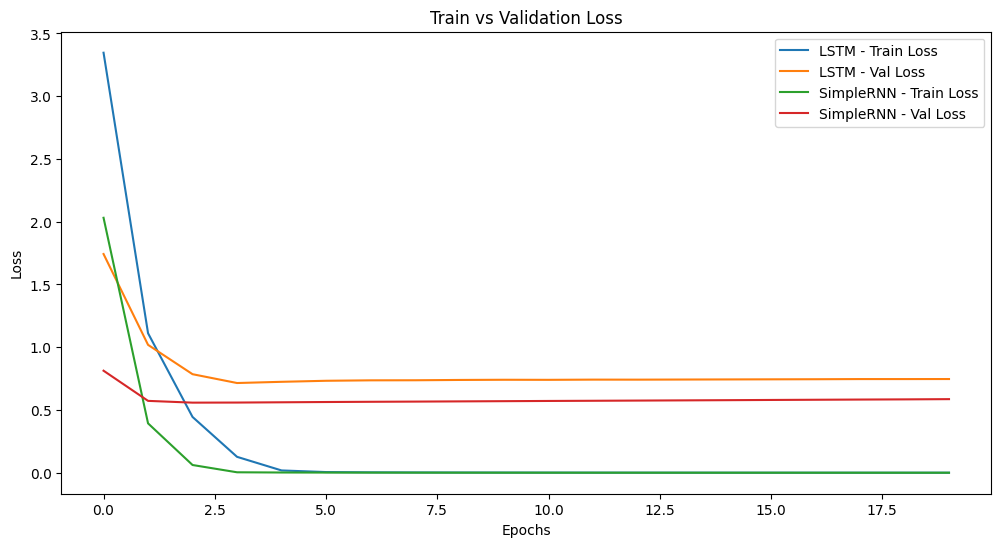

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for name, result in results.items():
    plt.plot(result["train_loss"], label=f"{name} - Train Loss")
    plt.plot(result["val_loss"], label=f"{name} - Val Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


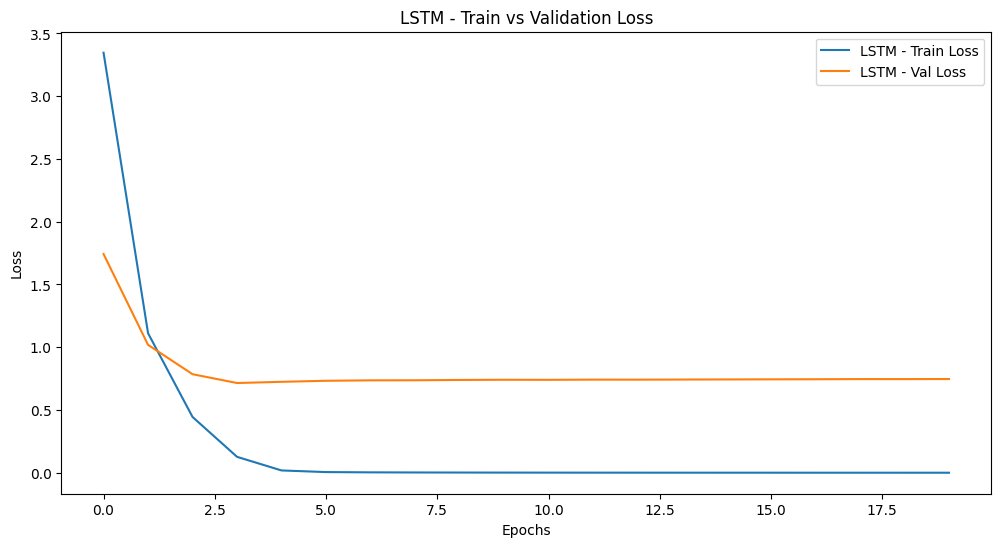

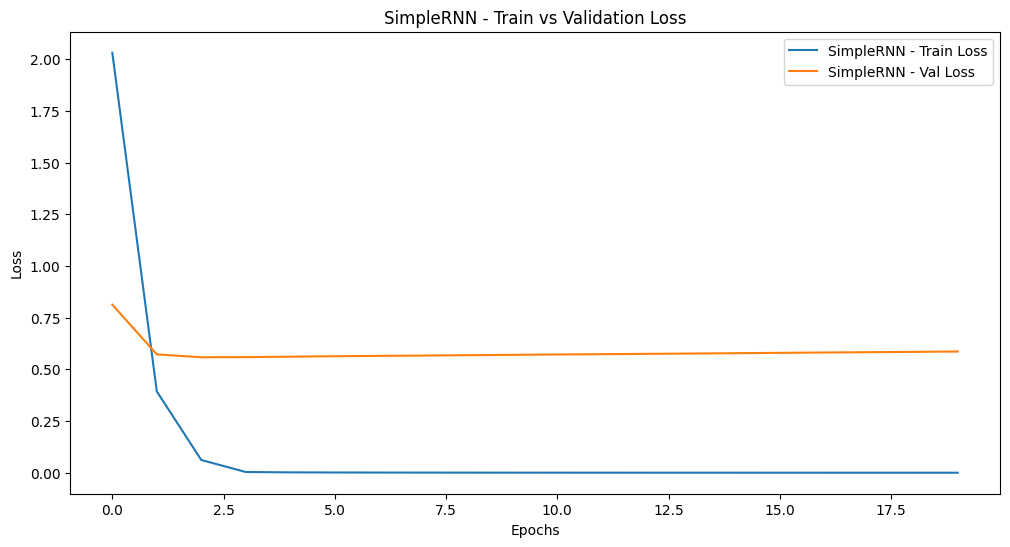

In [ ]:
for name, model in models.items():
    plt.figure(figsize=(12, 6))  # Create a new figure for each model
    plt.plot(results[name]["train_loss"], label=f"{name} - Train Loss")
    plt.plot(results[name]["val_loss"], label=f"{name} - Val Loss")
    plt.title(f"{name} - Train vs Validation Loss")  # Model-specific title
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
